In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print('Tensorflow version = {}'.format(tf.__version__))

Tensorflow version = 2.3.0


In [2]:
# Reading the data from file
df = pd.read_csv('spam.csv', encoding = 'latin-1')

df.head()

,class,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Defining label data
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
df.dropna(inplace = True)
labels = df['class'].map({'ham':1, 'spam':'0' })
labels = np.array(labels).astype(float)

print(labels.shape)
print(df['class'].value_counts())

(5572,)
ham     4825
spam     747
Name: class, dtype: int64


In [4]:
# Defining feature data
sentences = []

for i in range(df.shape[0]):
    string = df.iloc[i]['message']
    string = re.sub('[^a-zA-Z]', ' ', string)
    string = string.lower()
    sentences.append(string)

sentences[:3]

['go until jurong point  crazy   available only in bugis n great world la e buffet    cine there got amore wat   ',
 'ok lar    joking wif u oni   ',
 'free entry in   a wkly comp to win fa cup final tkts   st may       text fa to       to receive entry question std txt rate t c s apply            over   s']

In [5]:
# Setting kep params and tokenizing the feature sentences
vocab_size = 2000
embedding_dim = 16
max_length = 20
trunc_type = 'post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

In [42]:
padded[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,   48,  332, 1407,  461,    7, 1802], dtype=int32)

In [6]:
# Reverse interpret an example sentence
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]), '\n')
print(sentences[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ok lar joking wif u oni 

ok lar    joking wif u oni   


In [7]:
# Combining feature and label data into a tensorflow dataset
# labels = labels.reshape(labels.shape[0], 1)
#data = np.concatenate((padded, labels), axis = 1)
# dataset = tf.data.Dataset.from_tensor_slices(data)

In [8]:
# Create validation set
training_ratio = 0.8

validation_padded = padded[int(len(padded)*training_ratio) : ]
validation_labels = labels[int(len(labels)*training_ratio) : ]

padded = padded[ : int(len(padded)*training_ratio)]
training_labels = labels[ : int(len(labels)*training_ratio)]

In [9]:
# Split the dataset internally into features and labels
# def split_feature_label(sentence):
#     feature = sentence[ : -1]
#     label = sentence[-1]
#     return feature, label
# 
# dataset = dataset.map(split_feature_label)

In [10]:
# Setting up batches
# batch_size = 16
# 
# dataset = dataset.batch(batch_size, drop_remainder = True)

In [11]:
# Defining and compiling the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                              embedding_dim,
                              input_length = max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 16)            32000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 41,997
Trainable params: 41,997
Non-trainable params: 0
_________________________________________________________________


In [9]:
training_labels.shape

(4457,)

In [15]:
# Training the model
history = model.fit(padded, training_labels,
                    epochs = 10,
                    validation_data = (validation_padded, validation_labels))

Epoch 1/10
140/140 [==============================] - 1s 9ms/step - loss: 0.3578 - accuracy: 0.8836 - val_loss: 0.1341 - val_accuracy: 0.9668
Epoch 2/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0791 - accuracy: 0.9798 - val_loss: 0.0676 - val_accuracy: 0.9785
Epoch 3/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0376 - accuracy: 0.9897 - val_loss: 0.0571 - val_accuracy: 0.9803
Epoch 4/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0220 - accuracy: 0.9948 - val_loss: 0.0596 - val_accuracy: 0.9803
Epoch 5/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0155 - accuracy: 0.9962 - val_loss: 0.0674 - val_accuracy: 0.9839
Epoch 6/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.0643 - val_accuracy: 0.9865
Epoch 7/10
140/140 [==============================] - 1s 6ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 0.0689 - val_accuracy: 0.9839
Epoch 

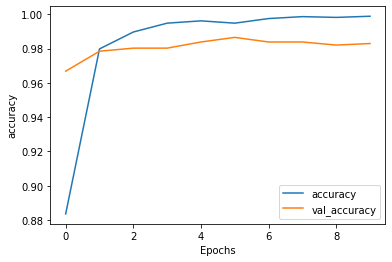

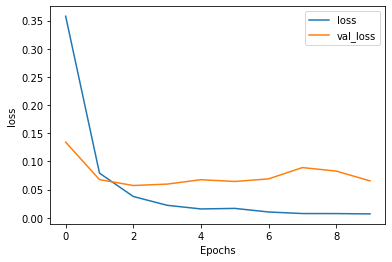

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [17]:
model.save('./model/spam_gru32.h5')

In [47]:
import io, json

tokenizer_json = tokenizer.to_json()
with io.open('./model/tokenizer.json', 'w', encoding = 'utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [49]:
from tensorflow.keras.models import load_model

model_file = './model/spam_gru32.h5'
model = load_model(model_file)

In [50]:
sentences = []
text = "Wanna Chat? Watch movie!"
text = re.sub('[^A-Za-z]', ' ', text)
text = text.lower()
sentences.append(text)

sentences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sentences, maxlen = max_length, truncating = trunc_type)
print(padded)

model.predict(padded)

# def Predict_Spam(sentence):
#     sentence = re.sub('[^A-Za-z]', ' ', sentence)
#     sentence = sentence.lower()
#     sentence =  tokenizer.texts_to_sequences(sentence)
#     sentence = pad_sequences(sentence, maxlen = max_length, truncating = trunc_type)
#     #padded = padded.reshape(padded.shape[0], 1)
#     result = model.predict(sentence)
#     return result

# result = Predict_Spam(text)
# print(result)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 338 231
  382 567]]


array([[0.9712149]], dtype=float32)